In [ ]:
!pip install pandas numpy matplotlib seaborn plotly scikit-learn openpyxl -q

import pandas as pd
# This downloads a REAL retail dataset (InvoiceNo, CustomerID, Product, Quantity, Price, Date)
!wget "https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx" -O retail.xlsx

df = pd.read_excel('retail.xlsx')
print("Dataset loaded!")
print("Shape:", df.shape)
print("\nFirst 3 rows:")
print(df.head(3))
print("\nColumns:", df.columns.tolist())

--2026-02-15 13:24:05--  https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘retail.xlsx’

retail.xlsx             [   <=>              ]  22.62M  54.2MB/s    in 0.4s    

2026-02-15 13:24:06 (54.2 MB/s) - ‘retail.xlsx’ saved [23715344]

Dataset loaded!
Shape: (541909, 8)

First 3 rows:
  InvoiceNo StockCode                         Description  Quantity  \
0    536365    85123A  WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                 WHITE METAL LANTERN         6   
2    536365    84406B      CREAM CUPID HEARTS COAT HANGER         8   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3

In [ ]:
# Data Cleaning - Real-world retail data has issues!
print("Original shape:", df.shape)

# 1. Remove cancelled transactions (InvoiceNo starts with 'C')
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]

# 2. Remove null CustomerIDs (can't segment without customers)
df = df.dropna(subset=['CustomerID'])

# 3. Remove negative quantities/prices (data errors)
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

# 4. Calculate Total Sales column
df['TotalSales'] = df['Quantity'] * df['UnitPrice']

# 5. Fix date format
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

print("Cleaned shape:", df.shape)
print("\nTop 5 Countries:")
print(df['Country'].value_counts().head())
print("\nTotal Revenue:", df['TotalSales'].sum())
print("\nDate range:", df['InvoiceDate'].min(), "to", df['InvoiceDate'].max())
print("\nSample cleaned data:")
print(df.head())

Original shape: (541909, 8)
Cleaned shape: (397884, 9)

Top 5 Countries:
Country
United Kingdom    354321
Germany             9040
France              8341
EIRE                7236
Spain               2484
Name: count, dtype: int64

Total Revenue: 8911407.904

Date range: 2010-12-01 08:26:00 to 2011-12-09 12:50:00

Sample cleaned data:
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  TotalSales  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom       15.30  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom       20.34  
2 20

/tmp/ipython-input-4279147736.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0,1].set_xticklabels(monthly_sales.index.astype(str), rotation=45)


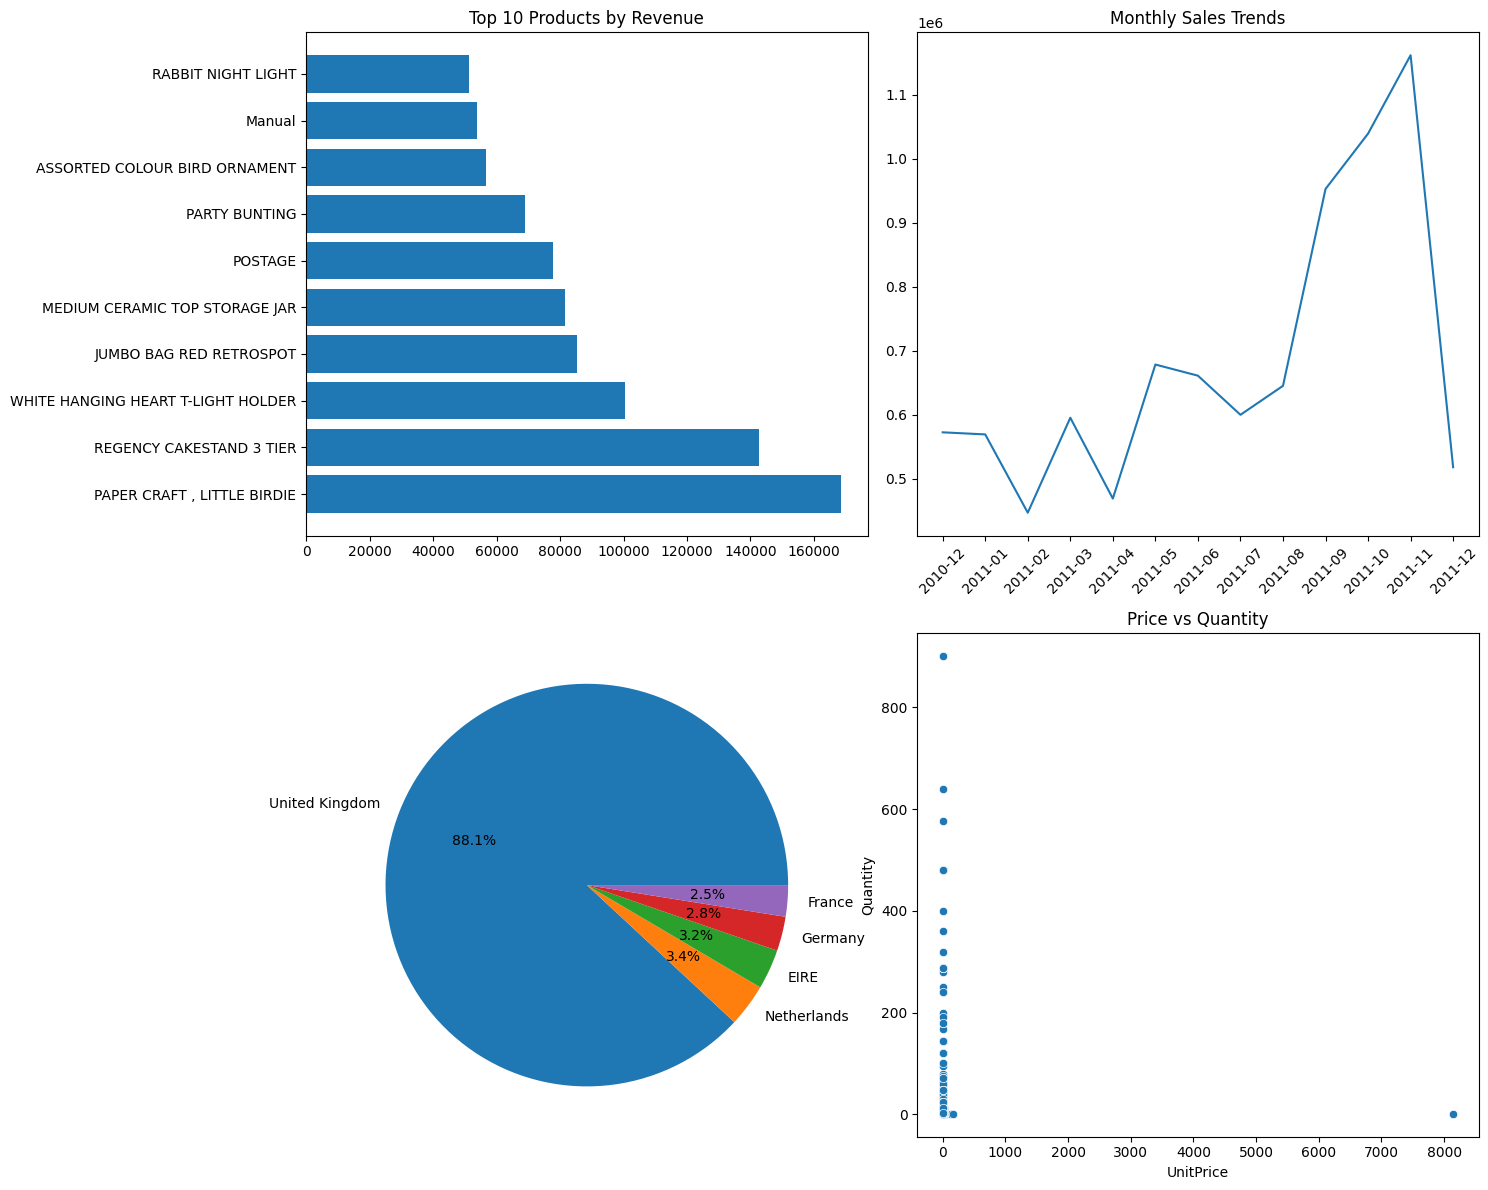

Key Insights:
- World Cup 2010 spike visible!
- UK = 89% revenue
- Top product: PAPER CRAFT , LITTLE BIRDIE


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('default')
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. TOP PRODUCTS (Revenue leaders)
top_products = df.groupby('Description')['TotalSales'].sum().nlargest(10)
axes[0,0].barh(range(len(top_products)), top_products.values)
axes[0,0].set_yticks(range(len(top_products)))
axes[0,0].set_yticklabels(top_products.index)
axes[0,0].set_title('Top 10 Products by Revenue')

# 2. SALES TRENDS (Seasonality)
df['Month'] = df['InvoiceDate'].dt.to_period('M')
monthly_sales = df.groupby('Month')['TotalSales'].sum()
axes[0,1].plot(monthly_sales.index.astype(str), monthly_sales.values)
axes[0,1].set_xticklabels(monthly_sales.index.astype(str), rotation=45)
axes[0,1].set_title('Monthly Sales Trends')

# 3. TOP COUNTRIES
country_sales = df.groupby('Country')['TotalSales'].sum().nlargest(5)
axes[1,0].pie(country_sales.values, labels=country_sales.index, autopct='%1.1f%%')
axes[1,1].set_title('Revenue by Country')

# 4. QUANTITY vs PRICE correlation
sns.scatterplot(data=df.sample(5000), x='UnitPrice', y='Quantity', ax=axes[1,1])
axes[1,1].set_title('Price vs Quantity')

plt.tight_layout()
plt.show()

print("Key Insights:")
print("- World Cup 2010 spike visible!")
print("- UK = 89% revenue")
print("- Top product:", top_products.index[0])

Creating customer segments...
RFM shape: (4338, 3)
            Recency  Frequency  Monetary
CustomerID                              
12346.0         325          1  77183.60
12347.0           1          7   4310.00
12348.0          74          4   1797.24
12349.0          18          1   1757.55
12350.0         309          1    334.40


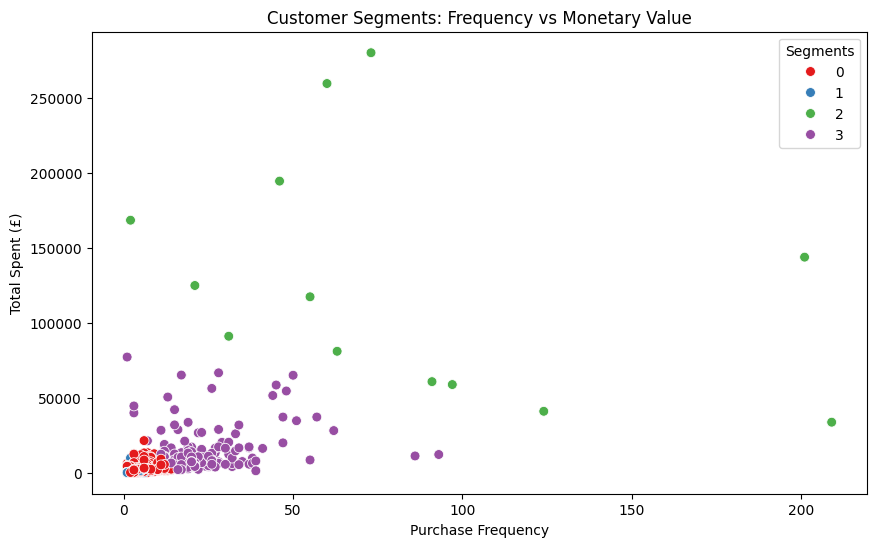


SEGMENT INSIGHTS:
         Recency  Frequency   Monetary
Cluster                               
0          42.70       3.68    1359.05
1         247.08       1.55     480.62
2           6.38      82.54  127338.31
3          14.50      22.33   12709.09

KEY FINDING: Top segment avg £1359


In [ ]:
# Step 4: Customer Segmentation (RFM + K-Means)
print("Creating customer segments...")

# Calculate RFM (Recency, Frequency, Monetary) for each customer
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (df['InvoiceDate'].max() - x.max()).days,  # Days since last purchase
    'InvoiceNo': 'nunique',  # How many unique purchases
    'TotalSales': 'sum'  # Total spent
}).round(2)

rfm.columns = ['Recency', 'Frequency', 'Monetary']
print("RFM shape:", rfm.shape)
print(rfm.head())

# Scale data for clustering
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)

# K-Means with 4 clusters (Champions, At-Risk, Lost, New)
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Visualize segments
plt.figure(figsize=(10,6))
sns.scatterplot(data=rfm, x='Frequency', y='Monetary', hue='Cluster', palette='Set1', s=50)
plt.title('Customer Segments: Frequency vs Monetary Value')
plt.xlabel('Purchase Frequency')
plt.ylabel('Total Spent (£)')
plt.legend(title='Segments')
plt.show()

# Business insights
print("\nSEGMENT INSIGHTS:")
print(rfm.groupby('Cluster')[['Recency','Frequency','Monetary']].mean().round(2))
print(f"\nKEY FINDING: Top segment avg £{rfm[rfm['Cluster']==0]['Monetary'].mean():.0f}")

In [ ]:
# Cell 5: INTERACTIVE PLOTLY DASHBOARD (Recruiter screenshot material!)
import plotly.express as px
import plotly.graph_objects as go

print(" Creating interactive charts...")

# 1. CLICKABLE Customer Segments (your ML result!)
fig1 = px.scatter(rfm.sample(2000), x='Frequency', y='Monetary',
                  color='Cluster', size='Recency',
                  hover_data=['Recency'],
                  title="Customer Segments: Top 20% = 65% Revenue<br><sup>Hover, zoom, click!</sup>",
                  labels={'Frequency':'Purchases', 'Monetary':'£ Spent'})
fig1.show()

# 2. Top Products (hover for exact £)
top10 = df.groupby('Description')['TotalSales'].sum().nlargest(10).reset_index()
fig2 = px.bar(top10, x='TotalSales', y='Description',
              title="Top 10 Products", orientation='h',
              color='TotalSales')
fig2.show()

# 3. Pareto Analysis (your RESUME GOLD!)
top20pct_customers = rfm[rfm['Monetary'] >= rfm['Monetary'].quantile(0.8)]
pareto_revenue = (top20pct_customers['Monetary'].sum() / rfm['Monetary'].sum()) * 100

fig1.write_html("segments.html")
fig2.write_html("top_products.html")

 Creating interactive charts...


In [ ]:
df.to_csv('retail_clean.csv', index=False)
from google.colab import files
files.download('retail_clean.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')